# ノート 9: 学習したモデルの解釈

### 目標: 学習したモデルを解釈する方法についていくつかの例を見ていきます

### 背景

このチュートリアルでは様々な種類の ML モデルの学習と評価を行ってきましたが、モデルは依然ブラックボックスに見えるかもしれません。
ML モデルが何を学習したのかを理解していくために ML モデルを解釈する方法（XAI: Explainable artificial intelligence と呼ばれる）をいくつか実践してみます。
様々な手法が提案されていますが、permutation interpolation と accumulated local effects (ALE) の 2 つの手法について説明していきます。
具体的な説明については論文の解説を参照してください。

このノートでは [scikit-explain](https://github.com/monte-flora/scikit-explain) というパッケージを使って 2 つの解釈手法をコードで実行します。

#### 補足

`sklearn.inspection` パッケージにも[Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html)
の実装があるので scikit-learn を使って同じことを試してみるのもよいだろう。


In [2]:
from pprint import pprint

import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

論文に沿って分類問題のモデルについて解釈を行ってみます。ノート 8 補足で永続化した学習済みのモデルを読み込みましょう。


In [3]:
import pickle
from pathlib import Path
import bz2

save_dir = Path("../datasets/sklearnmodels/classification/allfeatures")
save_files = [
    save_dir / "LogisticRegression.pkl",
    save_dir / "NaiveBayes.pkl",
    save_dir / "DecisionTree.pkl.bz2",
    save_dir / "RandomForest.pkl.bz2",
    save_dir / "GradientBoostedTrees.pkl.bz2",
]

model_list = []

for save_file in save_files:
    if save_file.suffix == ".bz2":
        with bz2.open(save_file, "rb") as f:
            model = pickle.load(f)
    else:
        with open(save_file, "rb") as f:
            model = pickle.load(f)
    model_list.append(model)

pprint(model_list)

[LogisticRegression(),
 GaussianNB(),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 GradientBoostingClassifier()]


検証データを読み込んで学習済みモデルから予測します。複数の特徴量を用いる場合は正規化を行うことが一般に必要となることに留意してください。


In [4]:
import sys

sys.path.insert(1, "../scripts/")
from aux_functions import load_n_combine_df


(X_train, y_train), (X_validate, y_validate), _ = load_n_combine_df(
    path_to_data="../datasets/sevir/",
    features_to_keep=np.arange(0, 36, 1),
    class_labels=True,
)

#
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

データセットを特徴量を列としたデータフレームに変換します。


In [5]:
column_names = [
    f"q{p:03d}{n}"
    for n in ["ir", "wv", "vi", "vl"]
    for p in [0, 1, 10, 25, 50, 75, 90, 99, 100]
]

X_df = pd.DataFrame(X_train, columns=column_names)  # 訓練データを使用するが検証データを利用する場合もある
X_df.head()

,q000ir,q001ir,q010ir,q025ir,q050ir,q075ir,q090ir,q099ir,q100ir,q000wv,...,q100vi,q000vl,q001vl,q010vl,q025vl,q050vl,q075vl,q090vl,q099vl,q100vl
0,-0.496423,-0.680095,-0.856844,-1.097814,-1.423917,-1.672151,-1.768832,-1.119766,0.037698,-0.460695,...,0.893267,-0.075823,-0.077287,-0.081944,-0.091565,-0.082707,0.066050,0.240730,0.102245,-0.155187
1,-0.529877,-0.663451,-0.860079,-1.094734,-1.454247,-1.726129,-1.780010,-1.303199,0.048498,-0.523225,...,0.795447,-0.075823,-0.077287,-0.081944,-0.091565,-0.081446,0.071456,0.252634,0.120325,0.142743
2,-0.487918,-0.653048,-0.859155,-1.096054,-1.476102,-1.779606,-1.795068,-1.441299,0.073422,-0.482621,...,0.837465,-0.075823,-0.077287,-0.081944,-0.091565,-0.078721,0.077002,0.264849,0.120325,0.024547
3,-0.514568,-0.649927,-0.860542,-1.101774,-1.483685,-1.834083,-1.796052,-1.446845,-0.038735,-0.482621,...,0.818790,-0.075823,-0.077287,-0.081944,-0.091565,-0.075701,0.077002,0.252634,0.102245,-0.244270
4,-0.516836,-0.647327,-0.862390,-1.107495,-1.485469,-1.863571,-1.808215,-1.456752,-0.678445,-0.498863,...,0.910163,-0.075823,-0.077287,-0.081944,-0.091565,-0.075701,0.077002,0.240730,0.084625,-0.492888


これで `skexplain` パッケージを使う準備はできました。`ExplainToolkit` クラスの `estimate` 引数に学習済みモデルを、`X`、`y` に 学習に使うデータを指定してインスタンスを初期化します。


In [6]:
import skexplain

estimators = estimators = [
    ("LogisticRegression", model_list[0]),
    ("NaiveBayes", model_list[1]),
    ("DecisionTree", model_list[2]),
    ("RandomForest", model_list[3]),
    ("GradientBoostedTrees", model_list[4]),
]
explainer = skexplain.ExplainToolkit(
    estimators=estimators,
    X=X_df,
    y=y_train,
)

## Permutation Importance

Permutation Importance 特徴量の重要度、すなわちどの特徴量が予測に強く影響しどの特徴量は予測に影響しないかを評価する手法です。

### Single-pass permutation importance

single-pass permutation importance は特徴量の 1 つをランダムに並び替えて学習モデルの予測を行うことで特徴量の重要度を評価します。
具体的には以下のような手順で評価が行われます。

1. 2 つ以上の特徴量でモデルを学習させ評価データで予測指標を求める。この指標の値が比較の基準となる。
2. 評価データのうち 1 つの特徴量をランダムに並べ替え学習モデルで予測を行い予測指標を求める。
3. この予測指標と基準となる予測指標の差（または比）を求め、これをその特徴量の重要度とする。
4. 2-3 をすべての特徴量について求め、特徴量の重要度を比較する。

このノートでは論文と同じく ROC 曲線から求める AUC を評価指標に使います。
モデルの予測に強く影響する特徴量であればランダムに替えられた意味のないデータが入力により予測性能が大きく低下するだろうという考えに基づいた手法です。

なお、このノートでは訓練データを重要度の計算に使っていますが検証データで重要度の計算を行う場合もあります。
例えば、訓練データを重要度の計算に使うとモデルが過学習となっている場合に過学習の要因となった訓練データのバイアスのある特徴量の重要度が大きくなる場合があり得ます（森下 2021）。
しかし、モデルが汎化されていればどちらが正しいという明確な方針はないようです。
このあたりの解説は[機械学習を解釈する技術（森下 2021）](https://gihyo.jp/book/2021/978-4-297-12226-3)で議論されています。


### Multi-pass permutation importance

残念なことに多くのデータセットには特徴量間の相関関係があります。
single-pass permutation importance では高い相関関係をもつ 2 つ以上の特徴量で予測性能に与える影響の評価が分散してしまうため、
特徴量の重要性を正しく示すことができない可能性があります。

この問題に対処する方法の一つとして multi-pass permutation importance があります。

single-pass permutation importance により決定された最も重要な特徴量をランダムに並び替えたまま固定して、
他の特徴量を再び並び替えて予測指標の変化を比較します。
並び替えたまま固定する特徴量を 1 つずつ増やしながらあらかじめ決めた数の特徴量がランダムに並び替えられるまでこれを繰り返します。
この手法を backward permutation importance と呼びます。
逆に全ての特徴量をランダムに並び変えてから、1 つずつ特徴量の順序を元に戻しながら最も予測指標を改善する特徴量を求めていく方法もあります。
これを forward permutation importance と呼びます。
相関関係のある特徴量の一方を並べ替えたままにすることで相関関係を壊した状態で重要度を求めることができるという考えに基づきます。

この方法は再学習を繰り返し行うため非常に時間がかかります（backward、forward それぞれ 8 並列の場合でも 20 分程度かかりました）。
`n_jobs` 変数で並列処理の数を指定することで時間を削減することができるので利用可能な CPU コアに応じて 2 以上の値を指定してみてください。
1 を指定した場合はかなり時間がかかるのでコードを実行後はしばらく他のことをして計算が終わるのを待ちましょう。
次のコードでは再計算を行わなくていいように結果を netCDF ファイルに保存するようにしています。

あらかじめ計算したデータを利用したい場合は計算と保存の実行をスキップして読み込みを行っているセルまで進んでください。


In [7]:
# backward permutation importance の計算
results_backward = explainer.permutation_importance(
    # multi pass により5番目の特徴量までを求める（1ならsingle pass）
    n_vars=5,
    # AUC を比較する指標とする
    evaluation_fn="auc",
    # 特徴量の並べ替えを行う回数（ランダム性のため指標変化が安定しないため複数回行ってその平均をとる）
    n_permute=10,
    # 指標の計算に用いるデータをサブサンプリングする割合 または サンプリング数
    # データ数が多い場合に一部のデータのみを用いることで計算時間を削減するオプション
    # 重要度の推定精度が低下する可能性があるがn_permutate と繰り返し回数を増やすことでトレードオフをコントロールできる
    subsample=0.25,
    # 並列数、利用可能なコア数に応じて変更
    n_jobs=8,
    # 計算の進行状況をデバッグ表示する
    verbose=True,
    random_seed=42,
    direction="backward",
)

Perm. Imp.: 100%|██████████| 5/5 [03:35<00:00, 43.19s/it]


In [8]:
from pathlib import Path

save_file = Path("../datasets/explanations/multipass_importance_auc_backward.nc")
if not save_file.parent.exists():
    save_file.parent.mkdir(parents=True)

# scikit-explain のメソッドはnetCDF4を出力時に圧縮を行っている
# 最新の python-netcdf のバージョン問題で保存できない場合があったためエラーになる場合は非圧縮で保存する
try:
    explainer.save(
        fname=save_file,
        data=results_backward,
    )
except Exception as e:
    print(e)
    results_backward.to_netcdf(save_file)
    print("save uncompressed netCDF")

<xarray.Dataset>
Dimensions:                                             (n_vars_multipass: 5,
                                                         n_permute: 10,
                                                         n_vars_singlepass: 36)
Dimensions without coordinates: n_vars_multipass, n_permute, n_vars_singlepass
Data variables: (12/25)
    backward_multipass_rankings__LogisticRegression     (n_vars_multipass) <U6 ...
    backward_multipass_scores__LogisticRegression       (n_vars_multipass, n_permute) float64 ...
    backward_singlepass_rankings__LogisticRegression    (n_vars_singlepass) <U6 ...
    backward_singlepass_scores__LogisticRegression      (n_vars_singlepass, n_permute) float64 ...
    original_score__LogisticRegression                  (n_permute) float64 0...
    backward_multipass_rankings__NaiveBayes             (n_vars_multipass) <U6 ...
    ...                                                  ...
    original_score__RandomForest                        (n_pe

In [9]:
# backward permutation importance の計算
results_forward = explainer.permutation_importance(
    n_vars=5,
    evaluation_fn="auc",
    n_permute=10,
    subsample=0.25,
    n_jobs=8,
    verbose=True,
    random_seed=42,
    direction="forward",
)

Perm. Imp.: 100%|██████████| 5/5 [03:56<00:00, 47.31s/it]


In [10]:
from pathlib import Path

save_file = Path("../datasets/explanations/multipass_importance_auc_forward.nc")
if not save_file.parent.exists():
    save_file.parent.mkdir(parents=True)

# scikit-explain のメソッドはnetCDF4を出力時に圧縮する
# 最新の python-netcdf のバージョンとの互換性により保存できない場合があったためエラーになる場合は非圧縮で保存する
try:
    explainer.save(
        fname=save_file,
        data=results_forward,
    )
except Exception as e:
    print(e)
    results_forward.to_netcdf(save_file)
    print("save uncompressed netCDF")

<xarray.Dataset>
Dimensions:                                            (n_vars_multipass: 5,
                                                        n_permute: 10,
                                                        n_vars_singlepass: 36)
Dimensions without coordinates: n_vars_multipass, n_permute, n_vars_singlepass
Data variables: (12/30)
    forward_multipass_rankings__LogisticRegression     (n_vars_multipass) <U6 ...
    forward_multipass_scores__LogisticRegression       (n_vars_multipass, n_permute) float64 ...
    forward_singlepass_rankings__LogisticRegression    (n_vars_singlepass) <U6 ...
    forward_singlepass_scores__LogisticRegression      (n_vars_singlepass, n_permute) float64 ...
    original_score__LogisticRegression                 (n_permute) float64 0....
    all_permuted_score__LogisticRegression             (n_permute) float64 0....
    ...                                                 ...
    forward_multipass_rankings__GradientBoostedTrees   (n_vars_multipas

時間のかかる計算をスキップした場合は次のセルを実行して永続化したモデルを読み込んでください。


In [11]:
import skexplain

explainer = skexplain.ExplainToolkit()

results_backward = explainer.load(
    fnames="../datasets/explanations/multipass_importance_auc_backward.nc"
)
results_forward = explainer.load(
    fnames="../datasets/explanations/multipass_importance_auc_forward.nc"
)

`skexplain` のプロットメソッドを使ってプロットしてみましょう。ロジスティック回帰の学習モデルについて特徴量の重要度をプロットします。


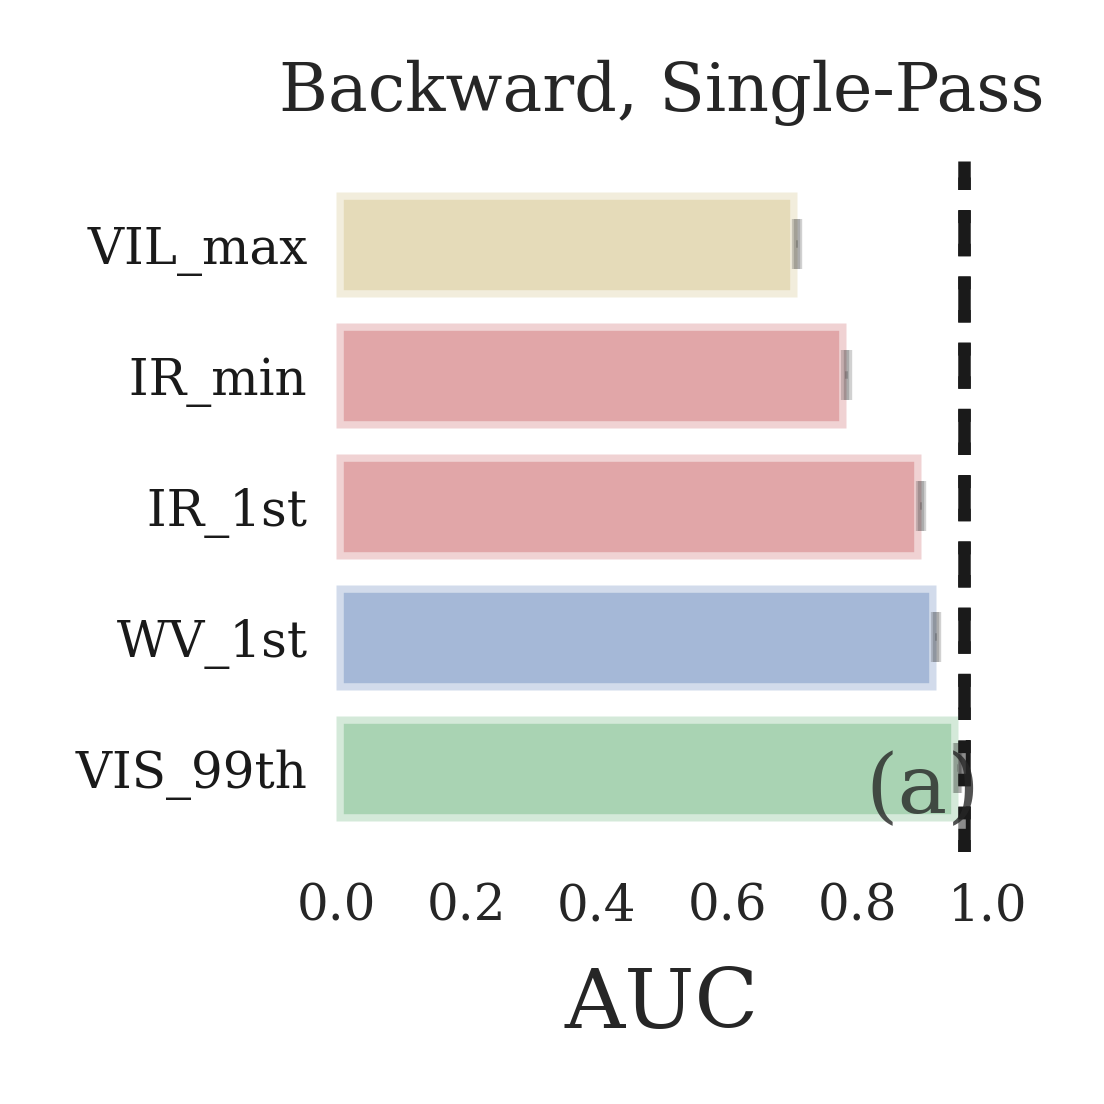

In [12]:
# カラム名と色、ラベルの対応
_color_dict = {"ir": "r", "wv": "b", "vi": "g", "vl": "y"}
_n_feature_names = {"ir": "IR", "wv": "WV", "vi": "VIS", "vl": "VIL"}
_p_feature_names = {
    0: "min",
    1: "1st",
    10: "10th",
    25: "25th",
    50: "50th",
    75: "75th",
    90: "90th",
    99: "99th",
    100: "max",
}
display_feature_names = {
    f"q{p:03d}{n}": f"{_n_feature_names[n]}_{_p_feature_names[p]}"
    for n in ["ir", "wv", "vi", "vl"]
    for p in [0, 1, 10, 25, 50, 75, 90, 99, 100]
}
color_dict = {
    f"q{p:03d}{n}": _color_dict[n]
    for n in ["ir", "wv", "vi", "vl"]
    for p in [0, 1, 10, 25, 50, 75, 90, 99, 100]
}

fig, ax = explainer.plot_importance(
    data=results_backward,
    panels=[("backward_singlepass", "LogisticRegression")],
    num_vars_to_plot=5,
    figsize=(2, 2),
    xlabels=["AUC"],
    display_feature_names=display_feature_names,
    feature_colors=color_dict,
)

ax.set_title("Backward, Single-Pass")
ax.axvline(
    results_backward.original_score__LogisticRegression.mean(), color="k", ls=":"
)
ax.set_xlim([0, 1])
fig.tight_layout()

x 軸は AUC の値で点線は基準値（学習データを並べ替えなしで求めた AUC）、棒グラフは y 軸のラベルの特徴量について並べ替えを行った場合の AUC です。
基準値から AUC が大きく減少した順、すなわち特徴量の重要度が高い順に上位 5 つを並べてあります。
色は特徴量の種類（VIL: 鉛直積算水蒸気量、IR: 赤外輝度温度、WV: 水蒸気輝度温度、VIS: 可視輝度温度）を表します。

VIL の 100%パーセンタイル（最大値）が最も重要な特徴量であり AUC を 0.2 減少させていることが分かります。
VIL が最も重要な特徴量であるという結果は、VIL が鉛直プロファイルの水蒸気量を観測したもので、発雷と関連があるという気象学的な知識（Watson et al. 1995）とも一致します。
2 番目に重要な特徴量は最低赤外輝度温度で、これも深い（背の高い）対流雲が低い赤外輝度温度と関連している気象学的知識と整合します。
以降は、最小赤外輝度温度、最小水蒸気輝度温度、と続きます。しかし、見て分かるように 3 番目以降の特徴量は AUC の減少量は大きくありません。

上図の結果は backward permutation importance の場合です。では forward permutation importance の場合でも同じ重要度の順序となるでしょうか？


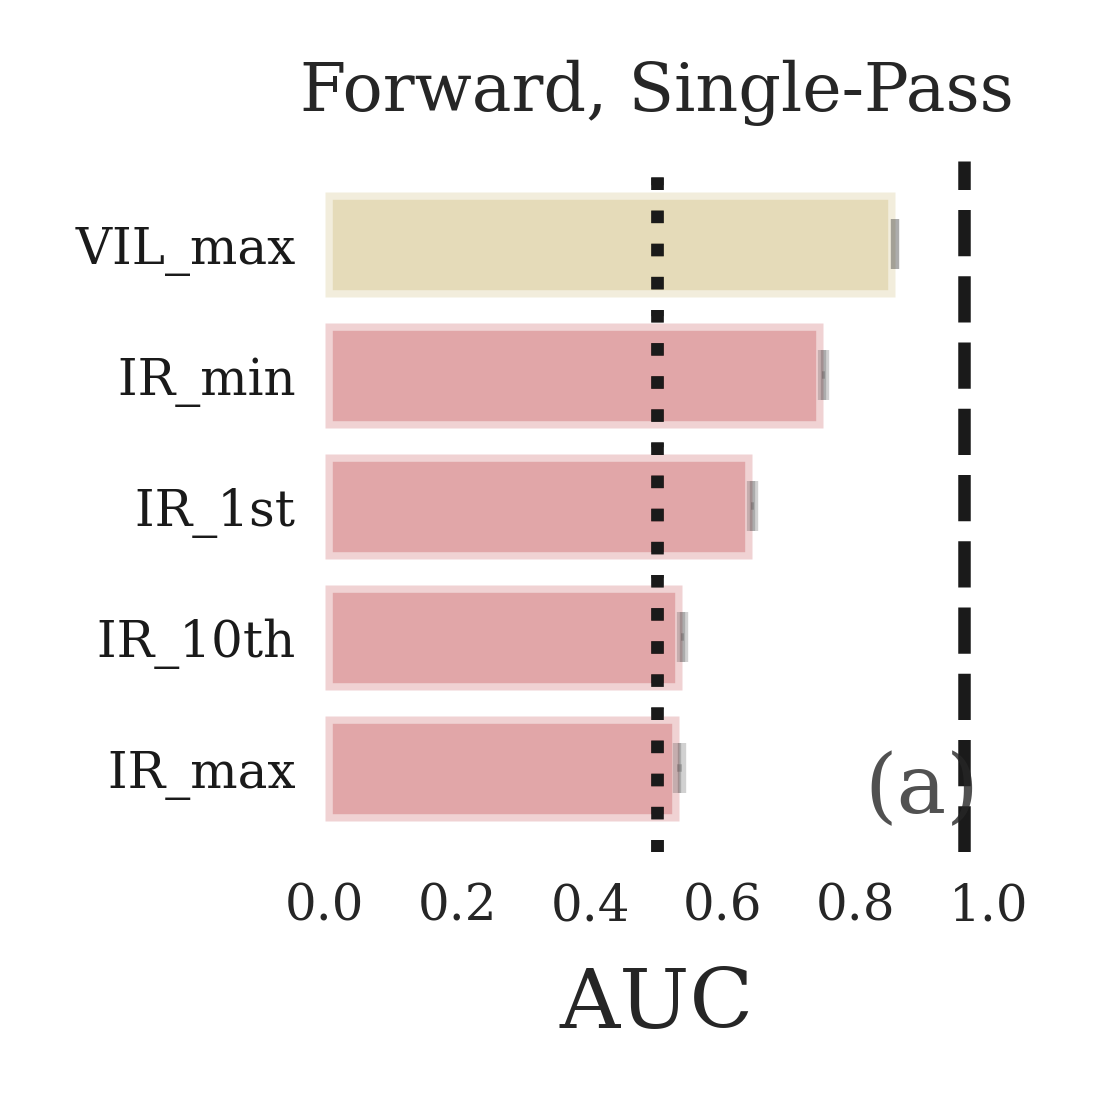

In [13]:
fig, ax = explainer.plot_importance(
    data=results_forward,
    panels=[("forward_singlepass", "LogisticRegression")],
    num_vars_to_plot=5,
    figsize=(2, 2),
    xlabels=["AUC"],
    display_feature_names=display_feature_names,
    feature_colors=color_dict,
)

ax.set_title("Forward, Single-Pass")
ax.axvline(
    results_forward.original_score__LogisticRegression.mean(),
    color="k",
    ls="--",
    zorder=0,
)
ax.axvline(
    results_forward.all_permuted_score__LogisticRegression.mean(), color="k", ls=":"
)
ax.set_xlim([0, 1])
fig.tight_layout()

x 軸は AUC の値で点線はすべての特徴量を並び替えた場合の AUC、破線が並べ替えを行わない場合の AUC です。
棒グラフはラベルに示した特徴量を **並べ替えなかった** 場合の AUC を表し、AUC を改善させた順に並べてあります。
backward permutation importance の場合と比べると 4 番目以降の結果が異なります。しかし 4 番目以降の特徴量による AUC の改善はわずかです。

※この結果は論文の結果とは異なりますが、AUC に対する寄与の差が小さいためランダム性により差が出る場合がある=さほど重要な差ではない、ということだと考えます

先に述べたように single-pass permutation の場合は特徴量間に相関関係があると正しい重要度を求めることができない場合があります。
multi pass permutation の結果も見てみましょう。


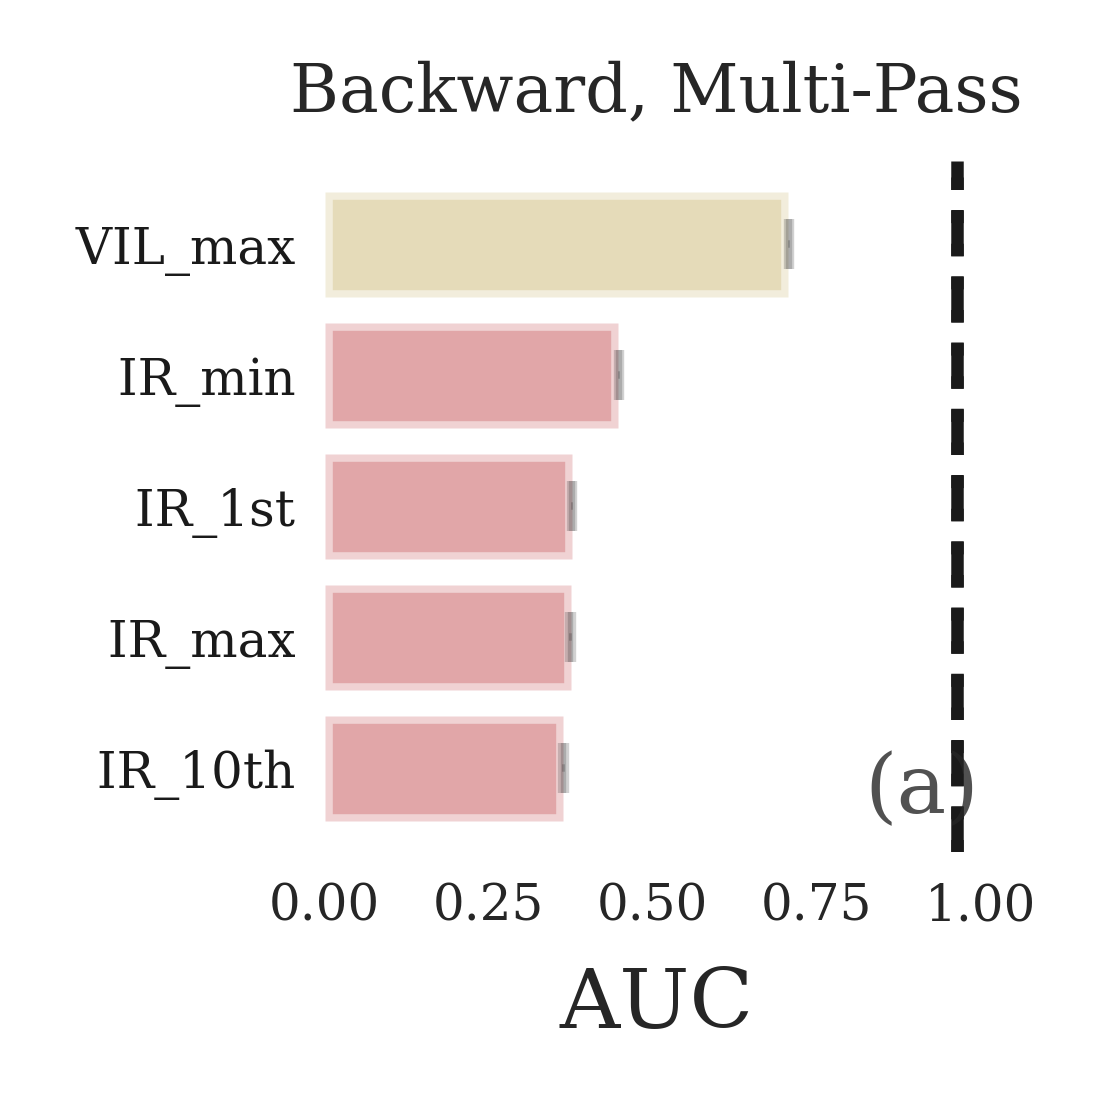

In [14]:
fig, ax = explainer.plot_importance(
    data=results_backward,
    panels=[("backward_multipass", "LogisticRegression")],
    num_vars_to_plot=5,
    figsize=(2, 2),
    xlabels=["AUC"],
    display_feature_names=display_feature_names,
    feature_colors=color_dict,
)

ax.set_title("Backward, Multi-Pass")
ax.axvline(
    results_backward.original_score__LogisticRegression.mean(), color="k", ls=":"
)
fig.tight_layout()

single-pass permutation とおおむね同じ特結果であるようです。

※3 番目以降は結果が異なる場合もありますが AUC への寄与が小さく差も小さいのでランダム性の影響を受けている可能性がある。


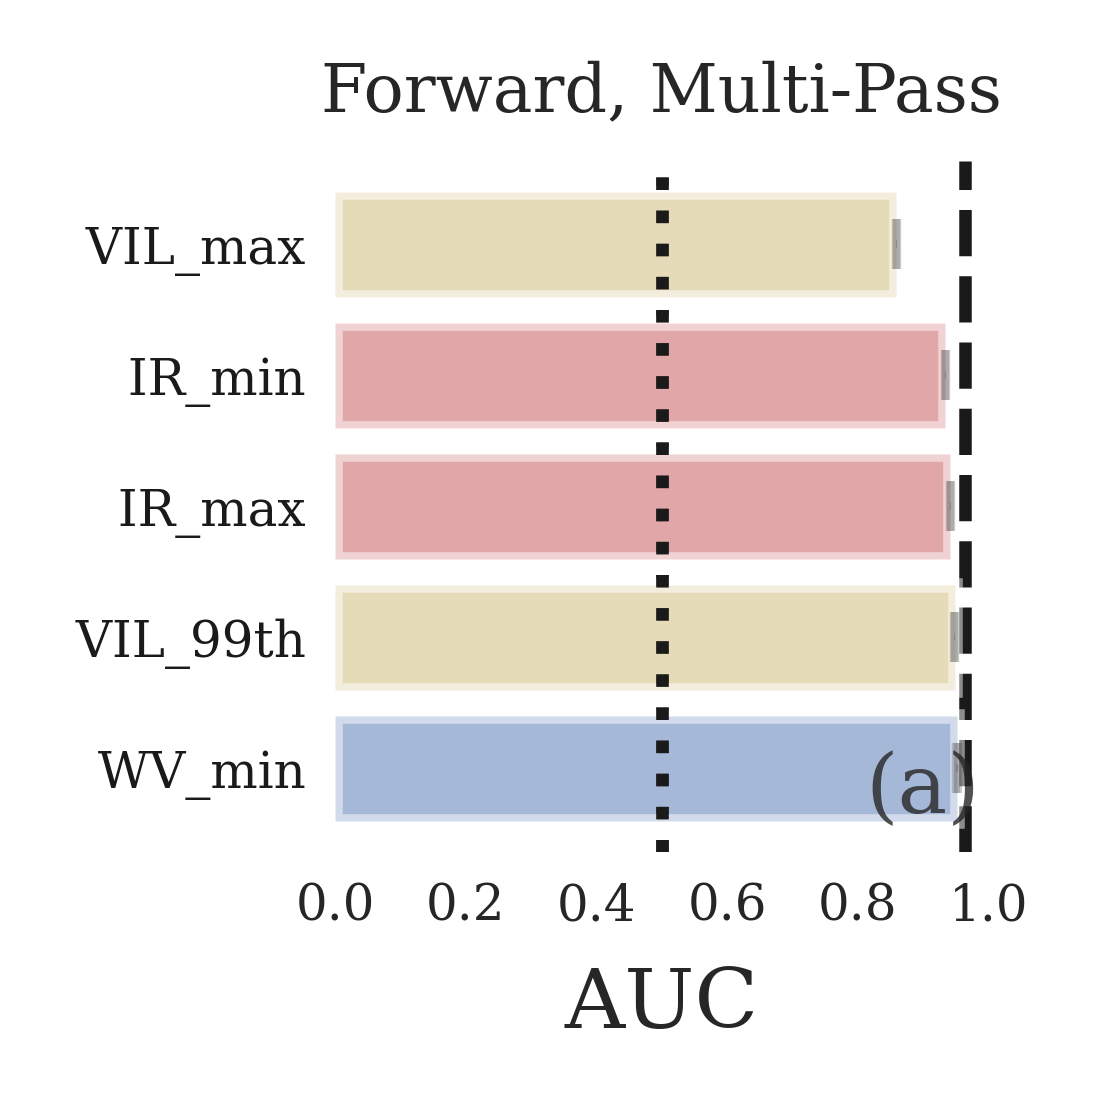

In [15]:
fig, ax = explainer.plot_importance(
    data=results_forward,
    panels=[("forward_multipass", "LogisticRegression")],
    num_vars_to_plot=5,
    figsize=(2, 2),
    xlabels=["AUC"],
    display_feature_names=display_feature_names,
    feature_colors=color_dict,
)

ax.set_title("Forward, Multi-Pass")
ax.axvline(
    results_forward.original_score__LogisticRegression.mean(),
    color="k",
    ls="--",
    zorder=0,
)
ax.axvline(
    results_forward.all_permuted_score__LogisticRegression.mean(), color="k", ls=":"
)
ax.set_xlim([0, 1])
fig.tight_layout()

5 番目までの結果はほぼ同じが、興味深いことに `q100_ir`（最大赤外輝度温度）が 重要な特徴量として示されています。
最大輝度温度は地表の温度を表す量であるとみなすこともできるのでこの結果は気象学的に見ても意味のある結果であるのかもしれません。

ここまでの結果をどのようにまとめるべきでしょうか？
例えば、すべての特徴量を使って学習させたランダムフォレストモデルの特徴量の重要度を調べて、 VIL 最大値の重要度の順序がロジスティック回帰の結果と一致することを示す方法があるでしょう。

`skexplain` は複数のモデルの結果をまとめてプロットすることができます。
ロジスティック回帰、ランダムフォレスト、勾配ブースト決定木について調べたときの上位 5 つの重要な特徴量の結果を見てみます。


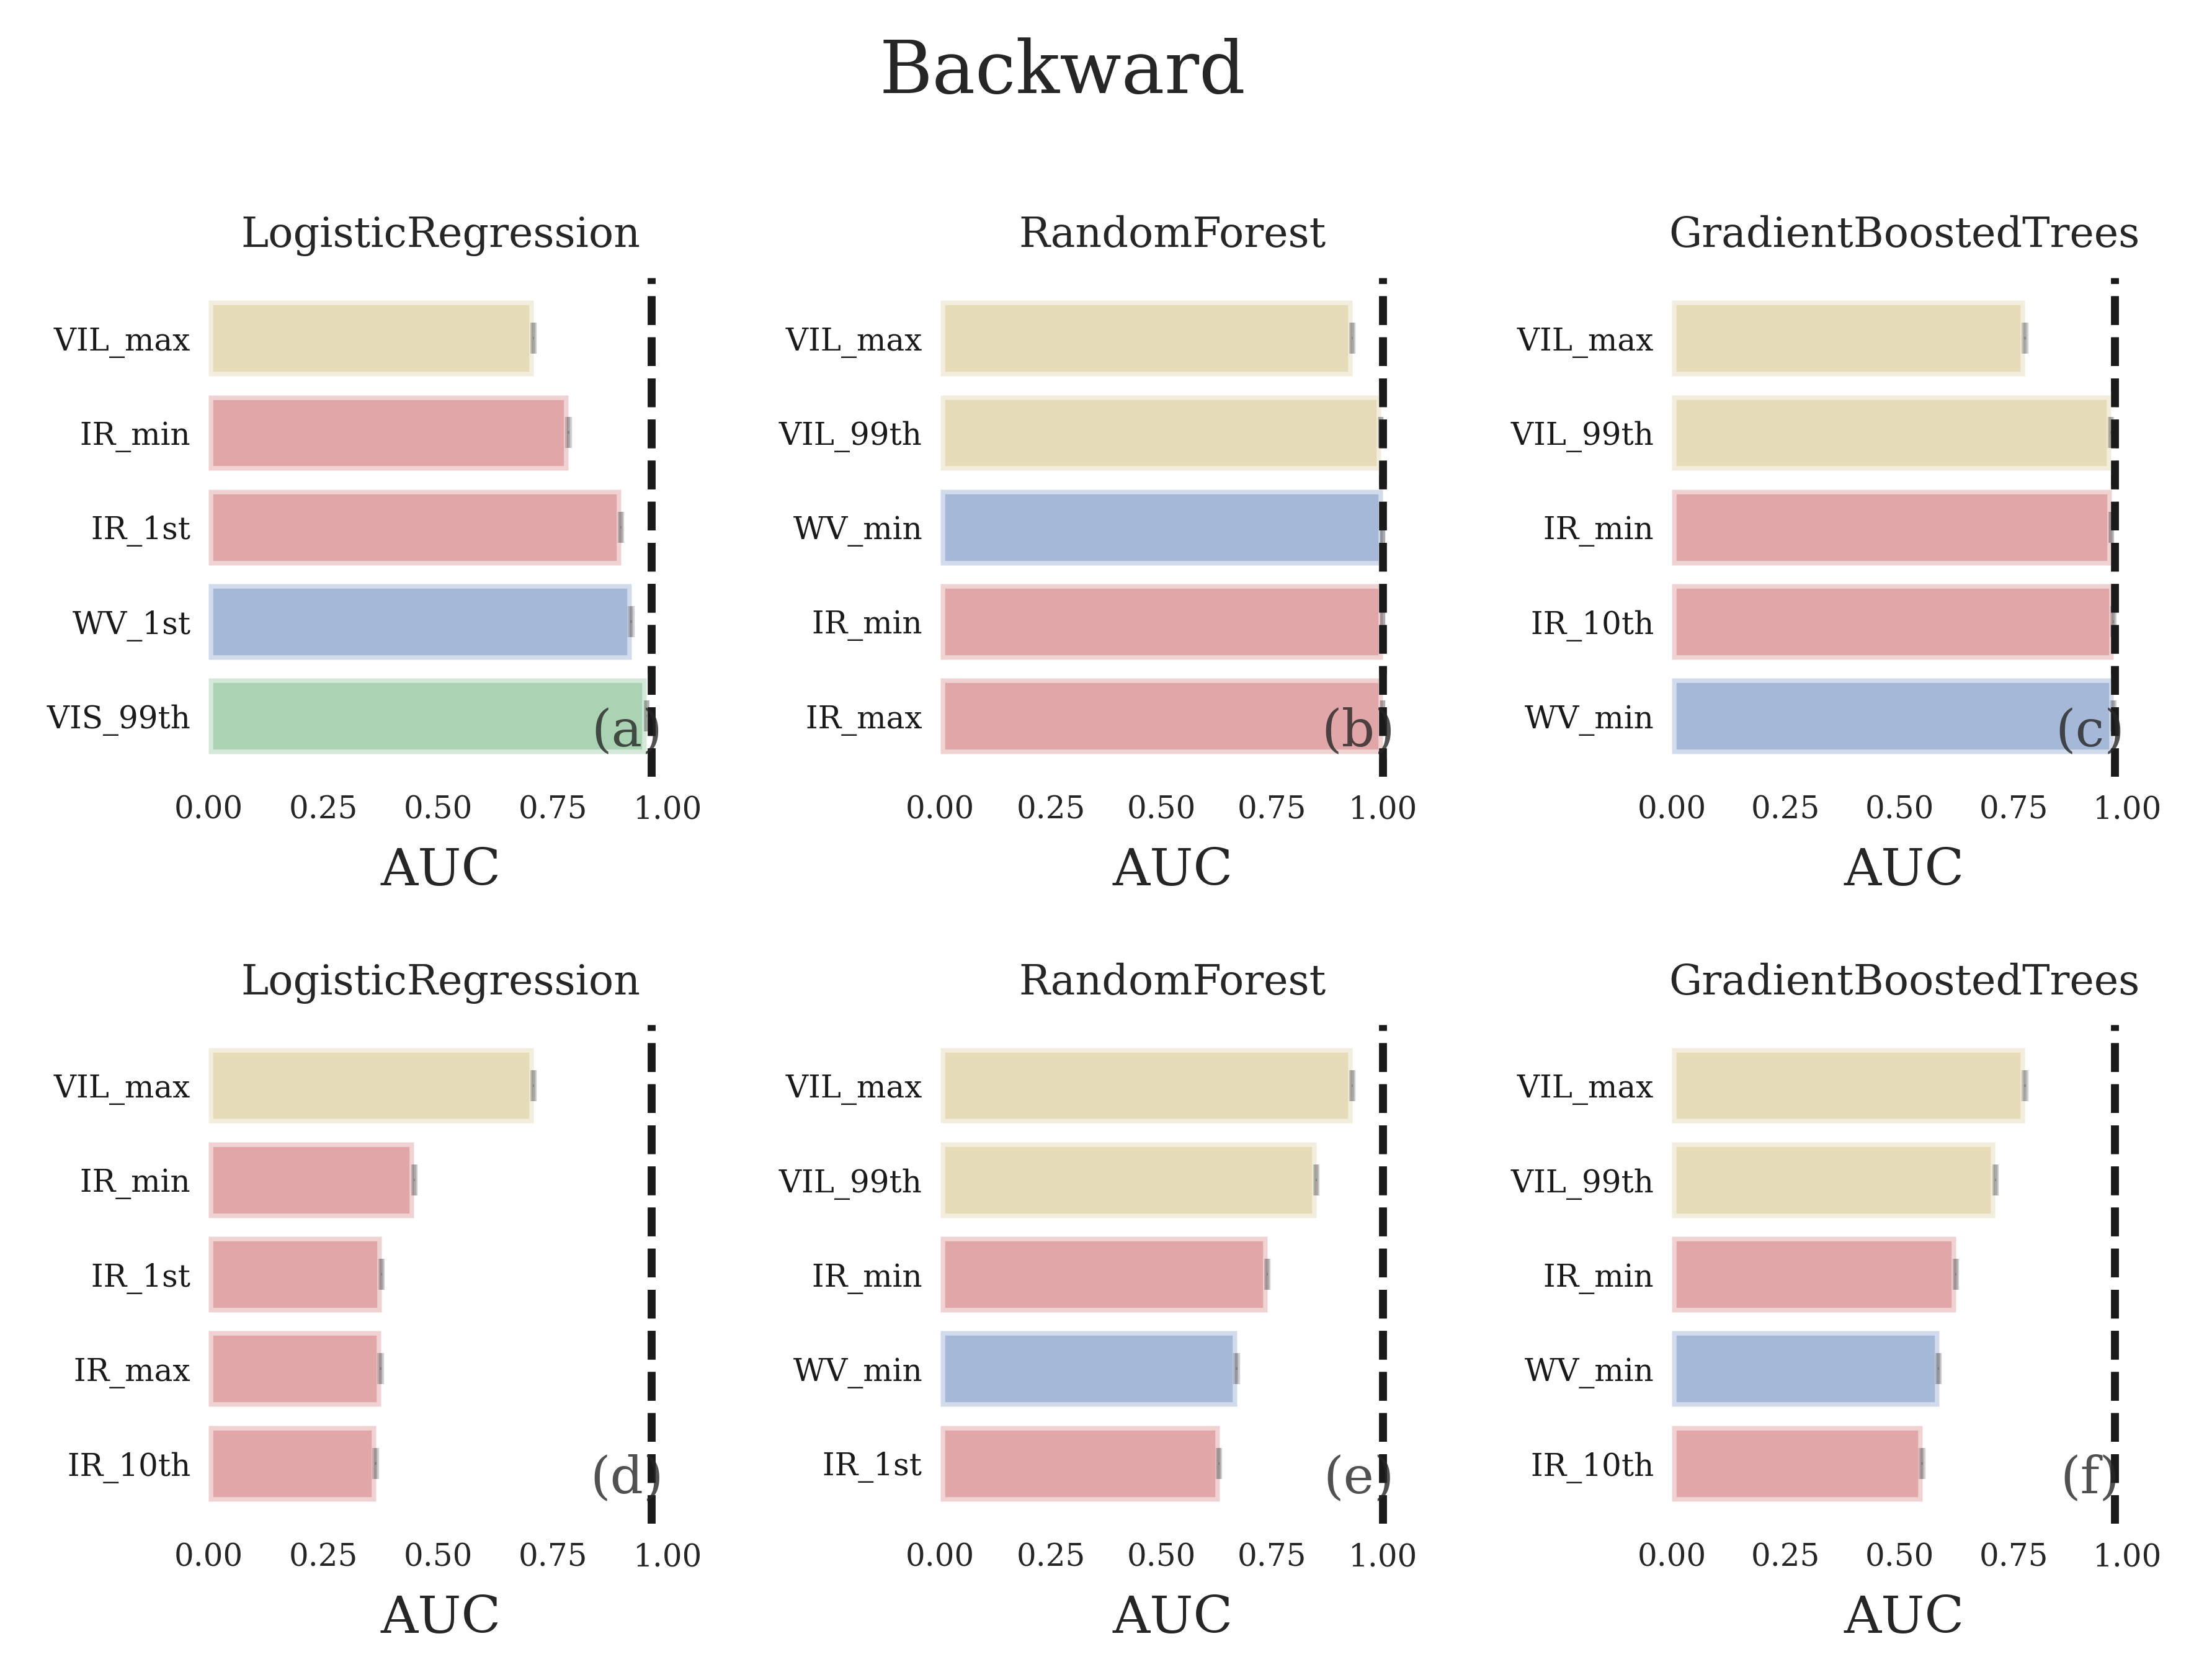

In [16]:
panels = [
    ("backward_singlepass", "LogisticRegression"),
    ("backward_singlepass", "RandomForest"),
    ("backward_singlepass", "GradientBoostedTrees"),
    ("backward_multipass", "LogisticRegression"),
    ("backward_multipass", "RandomForest"),
    ("backward_multipass", "GradientBoostedTrees"),
]

fig, axes = explainer.plot_importance(
    data=[results_backward] * 6,
    panels=panels,
    num_vars_to_plot=5,
    xlabels=["AUC"] * 6,
    display_feature_names=display_feature_names,
    feature_colors=color_dict,
)

axes = axes.ravel()
for i, ax in enumerate(axes):
    method = panels[i][1]
    ax.axvline(results_backward["original_score__" + method].mean(), color="k", ls="--")

fig.suptitle("Backward")
fig.tight_layout()

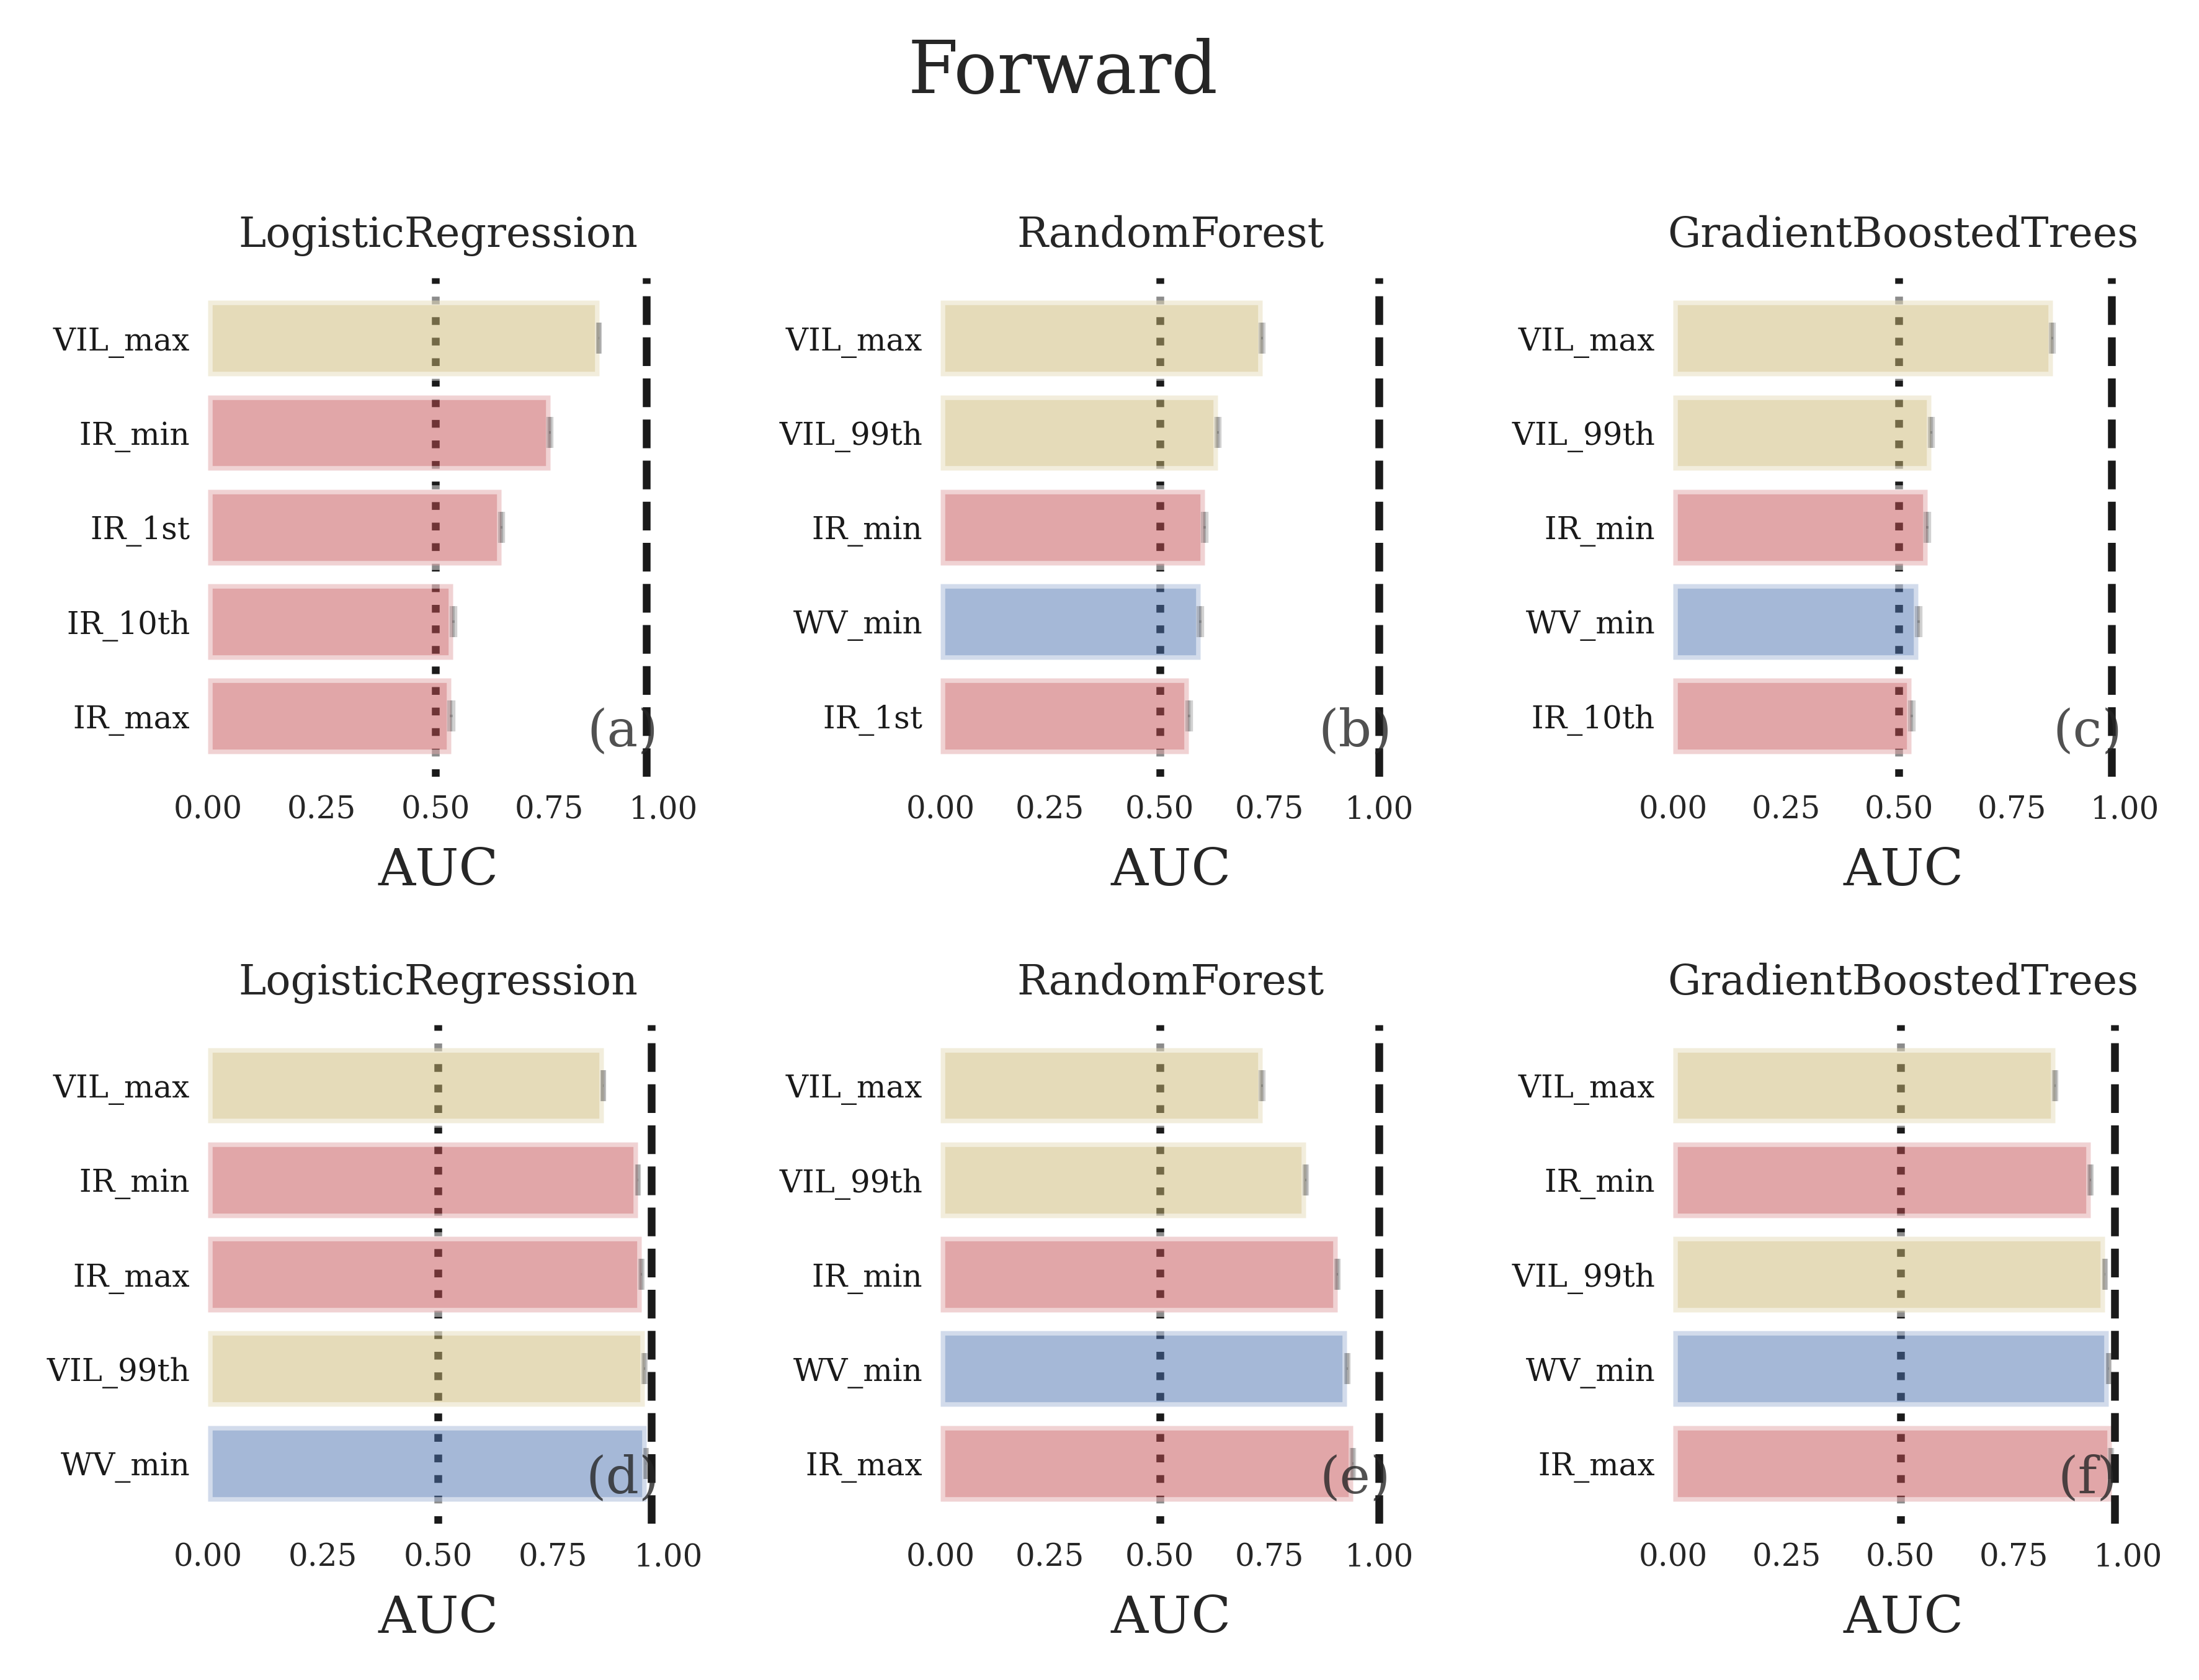

In [17]:
panels = [
    ("forward_singlepass", "LogisticRegression"),
    ("forward_singlepass", "RandomForest"),
    ("forward_singlepass", "GradientBoostedTrees"),
    ("forward_multipass", "LogisticRegression"),
    ("forward_multipass", "RandomForest"),
    ("forward_multipass", "GradientBoostedTrees"),
]

fig, axes = explainer.plot_importance(
    data=[results_forward] * 6,
    panels=panels,
    num_vars_to_plot=5,
    xlabels=["AUC"] * 6,
    display_feature_names=display_feature_names,
    feature_colors=color_dict,
)

axes = axes.ravel()
for i, ax in enumerate(axes):
    method = panels[i][1]
    ax.axvline(results_forward["original_score__" + method].mean(), color="k", ls="--")

fig.suptitle("Forward")
fig.tight_layout()

VIL の最大値が最も重要な特徴量という結果はランダムフォレストモデルでも一致します。また、赤外画像や水蒸気画像の最低輝度温度も重要な特徴量として評価されていることも分かります。


# Accumulated Local Effects (ALE)

permutation importance は学習モデルに対して一定の解釈を与えてくれる便利な方法です。
しかし、どの特徴量が重要であるかに対する解釈は与えてくれますが、各特徴量の寄与に対する定量的な解釈はそれほど与えてくれません。
ここまで見てきた例の場合 VIL_max が重要であることが理解できても、
「VIL_max が変化した場合に ML モデルはどう変化するだろう？VIL_max が大きくなると予測は悪くなるだろうか？良くなるだろうか？」といった疑問は以前残っています。

こうした疑問に対して解釈を与えてくれる方法として Accumulated Local Effects (ALE) という手法があります。
数学的に厳密な説明はかなり複雑のため省略しますが大まかには次のような手法となります。

1. 訓練データの特徴量の値の範囲をいくつかの区間に分割します。
   - 各サンプルを特徴量 IR_min の値に応じて 5 度刻みのグループに分割します。
2. ある区間に含まれるグループのサンプルについて注目している特徴量が区間の両端の値になるときの予測値を計算しその差分をこの区間の Local Effect とします。Local Effect をこの区間で特徴量の変化が予測に与える定量的な効果とみなします。
   - IR_min が-30 度から-25 度の区間にあるサンプルについて、IR_min の値のみを-30 度にした場合の予測と-25 度にした場合の予測を行いその差を求めます。
3. 全区間について Local Effect を足し合わせる（積分する）ことで特徴量の変化に対する学習モデルの変化を特徴量の関数として得ることができます。

全ての特徴量について ALE を繰り返し行うことも可能ですが、permutation importance で重要な特徴量として得られた VIL_max, IR_min, WV_min について ALE の解釈と一致するかについて調べてみましょう。
ALE を計算するには `xplainer.ale` パッケージが利用できます。


In [18]:
estimators = [("LogisticRegression", model_list[0])]
explainer = skexplain.ExplainToolkit(
    estimators=estimators,
    X=X_df,
    y=y_validate,
)

# 1D ALE を求める
ale_1d_ds = explainer.ale(
    # ALE を求める特徴量（データフレーム X に対するラベルで与える）
    # VIL_max, IR_min, WV_min に対応するラベル
    features=["q100vl", "q000ir", "q000wv"],
    # Bootstrapサンプリングの回数
    # Bootstrapサンプリングによりサブサンプリングのランダム性を抑えて信頼度区間を得ることができる
    n_bootstrap=4,
    # 指標の計算に用いるデータをサブサンプリングする割合 または サンプリング数
    # データ数が多い場合に一部のデータのみを用いることで計算時間を削減するオプション
    subsample=1000,
    # 並列数
    n_jobs=1,
    # 区間の分割数
    n_bins=20,
)

ALE Numerical Features: 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]


`explainer.plot_ale` メソッドでプロットします。


Text(0.5, 0, '$WV_{min}$, [$\\sigma$]')

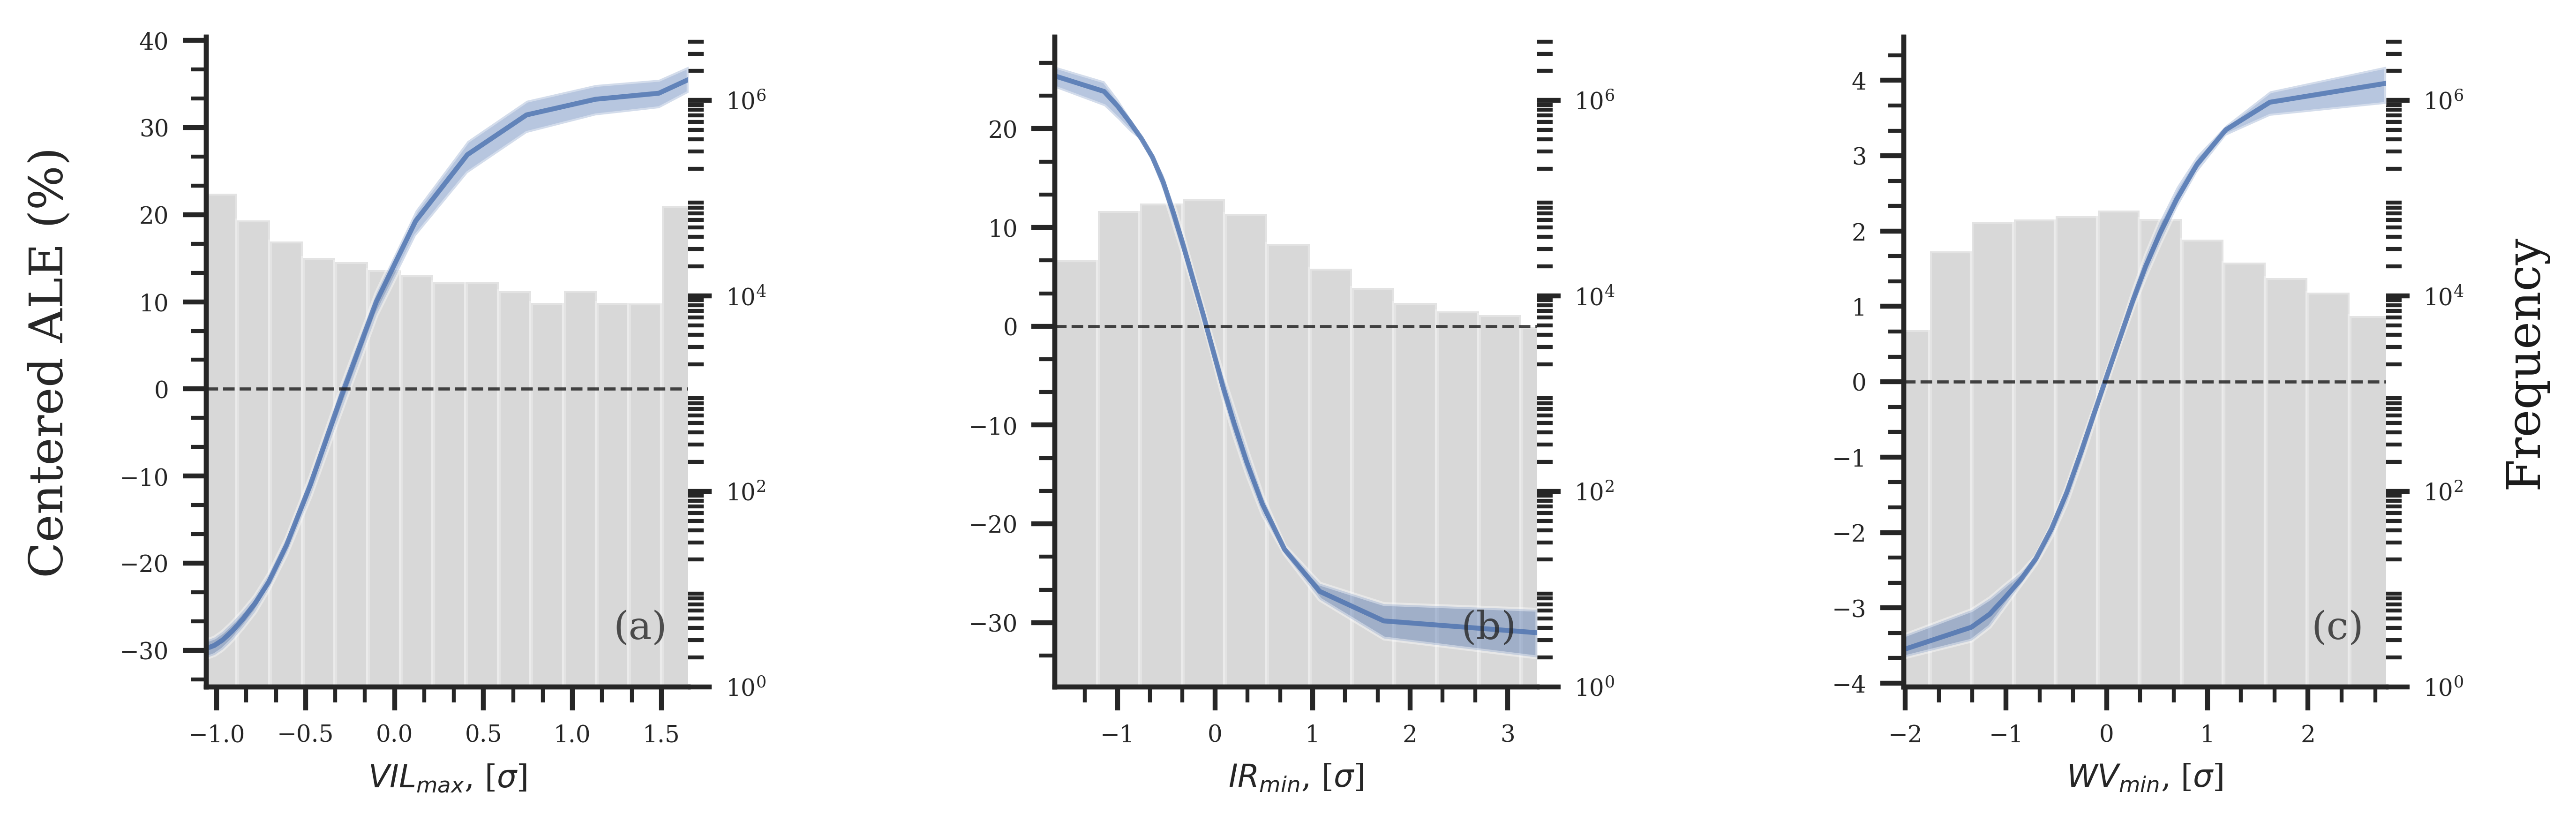

In [19]:
fig, axes = explainer.plot_ale(
    ale=ale_1d_ds,
    figsize=(10, 3),
    hist_color="grey",
    line_kws={"line_colors": ["b", "r", "g"]},
)

# ラベルの設定
axes[0].set_xlabel(r"$VIL_{max}$, [$\sigma$]")
axes[1].set_xlabel(r"$IR_{min}$, [$\sigma$]")
axes[2].set_xlabel(r"$WV_{min}$, [$\sigma$]")

ブートストラップ法により得られた信頼区間はあくまで ALE の平均値に対する信頼区間であることに注意してください。

x 軸は着目している特徴量の値（訓練データは分散が 1 となるように正規化されていることに注意）、y 軸が折れ線グラフで表された ALE の値、
右 y 軸はヒストグラムで表された各区間で ALE の計算に使われたサンプル数を表します。

まず図(a)から解釈してみましょう。
VIL_max が大きくなるほど発雷が含まれる確率が大きく変化することがわかります。
これは、VIL_max が大きいほど対流雲が強まり発雷が起きやすくなることに対応していると解釈できます。
また、図(b)からは IR_min が小さいほど発雷が含まれる確率が大きくなることが分かります。
図(c)からは WV_min が大きいほど発雷が含まれる確率が大きくなっており、
これは水蒸気画像輝度温度が大きい方が発雷しやすいことを示しており、気象学的な知識から期待される結果とは逆になっています。
これが物理的に正しい結果であるかは分かりませんが、図(c)の特徴量に対する ALE の値は VIL_max や IR_min より 1 桁小さいため
全体の予測に対しての影響は弱そうに見えます。

x 軸のスケールを元に戻すことでより見通しはよくなります。


Text(0.5, 0, '$WV_{min}$, [$^{\\circ}$C]')

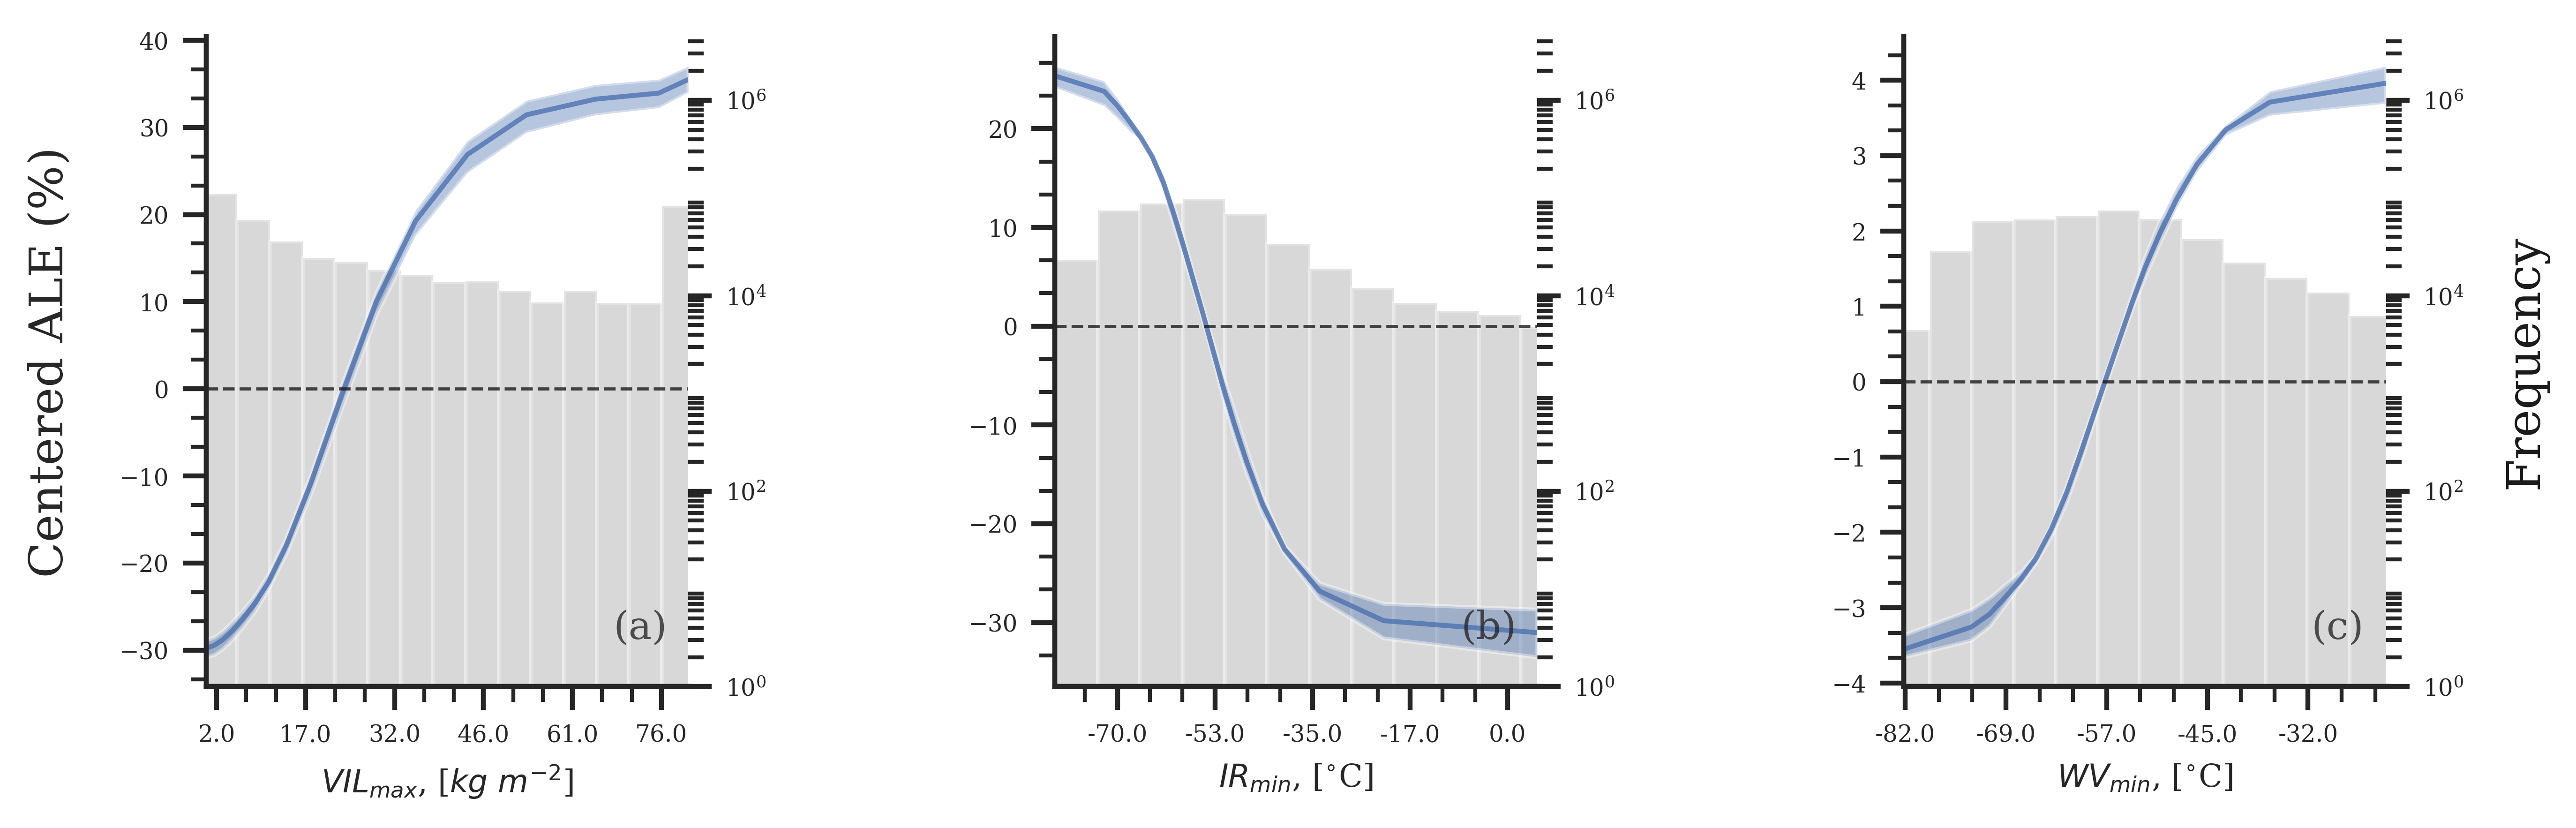

In [20]:
fig, axes = explainer.plot_ale(
    ale=ale_1d_ds,
    figsize=(10, 3),
    hist_color="grey",
    line_kws={"line_colors": ["b", "r", "g"]},
)

# 各図の特徴量のスケールを元に戻す
# 正規化に用いた sklearn.StandardScaler から平均と標準偏差を取得する
ax = axes[0]
xticks = ax.get_xticks()
idx = column_names.index("q100vl")
xlabels = np.round(xticks * scaler.scale_[idx] + scaler.mean_[idx])
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"$VIL_{max}$, [$kg \ m^{-2}$]")

ax = axes[1]
xticks = ax.get_xticks()
idx = column_names.index("q000ir")
xlabels = np.round(xticks * scaler.scale_[idx] + scaler.mean_[idx])
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"$IR_{min}$, [$^{\circ}$C]")


ax = axes[2]
xticks = ax.get_xticks()
idx = column_names.index("q000wv")
xlabels = np.round(xticks * scaler.scale_[idx] + scaler.mean_[idx])
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"$WV_{min}$, [$^{\circ}$C]")

先ほどの図と解釈は同じですがより分かりやすくなりました。他の学習モデルの場合もプロットしてみましょう。


In [21]:
estimators = estimators = [
    ("LogisticRegression", model_list[0]),  # ロジスティック回帰
    ("RandomForest", model_list[3]),  # ランダムフォレスト
    ("GradientBoostedTrees", model_list[4]),  # 勾配ブースト決定木
]
explainer = skexplain.ExplainToolkit(
    estimators=estimators,
    X=X_df,
    y=y_validate,
)

ale_1d_ds = explainer.ale(
    # VIL_max, IR_min, WV_min に対応するラベル
    features=["q100vl", "q000ir", "q000wv"],
    n_bootstrap=1,
    subsample=1000,
    n_jobs=4,
    n_bins=20,
)

ALE Numerical Features: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


Text(0.5, 0, '$WV_{min}$, [$^{\\circ}$C]')

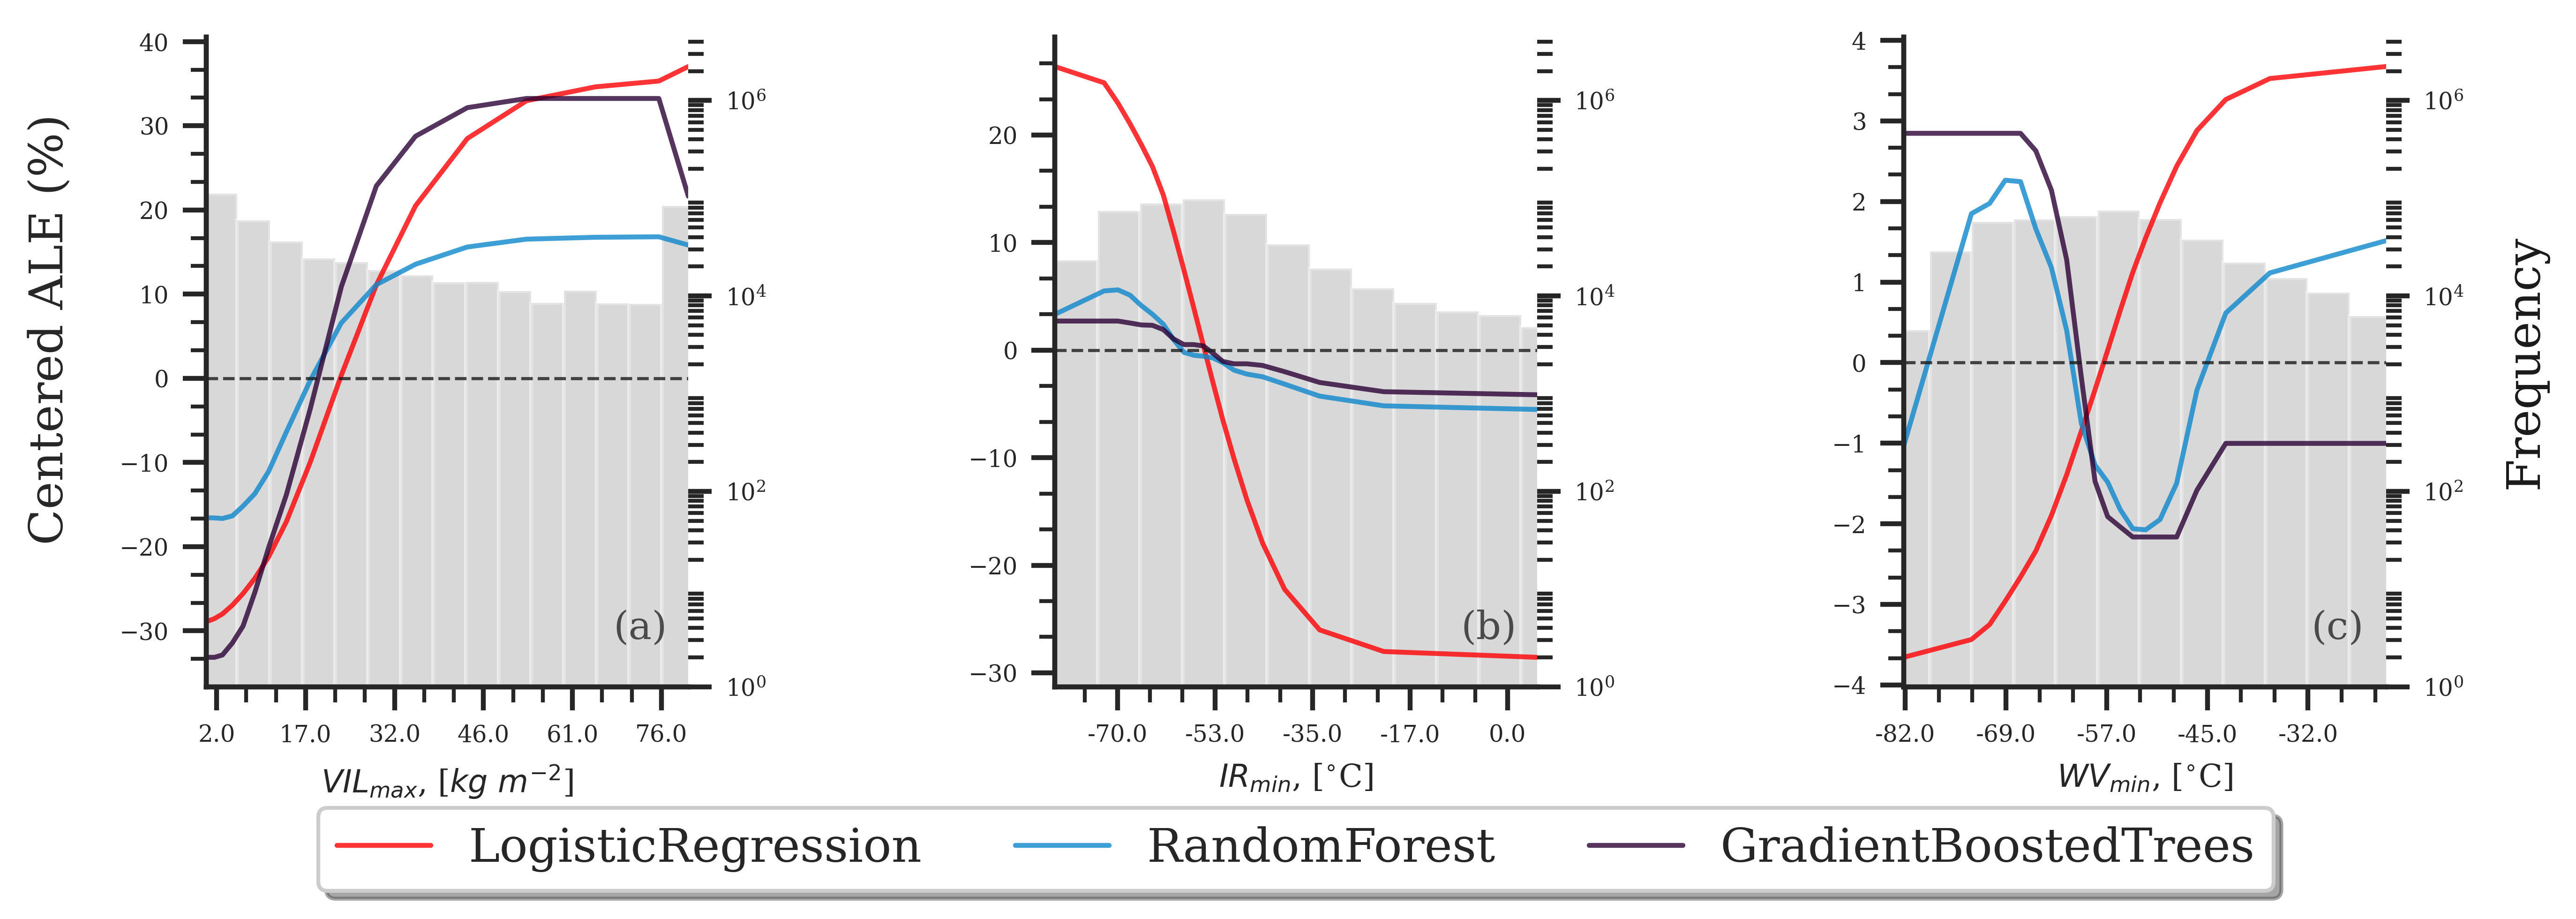

In [22]:
fig, axes = explainer.plot_ale(
    ale=ale_1d_ds,
    figsize=(10, 3),
    hist_color="grey",
    line_colors=["blue", "red", "green"],
)


# 各図の特徴量のスケールを元に戻す
# 正規化に用いた sklearn.StandardScaler から平均と標準偏差を取得する
ax = axes[0]
xticks = ax.get_xticks()
idx = column_names.index("q100vl")
xlabels = np.round(xticks * scaler.scale_[idx] + scaler.mean_[idx])
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"$VIL_{max}$, [$kg \ m^{-2}$]")

ax = axes[1]
xticks = ax.get_xticks()
idx = column_names.index("q000ir")
xlabels = np.round(xticks * scaler.scale_[idx] + scaler.mean_[idx])
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"$IR_{min}$, [$^{\circ}$C]")


ax = axes[2]
xticks = ax.get_xticks()
idx = column_names.index("q000wv")
xlabels = np.round(xticks * scaler.scale_[idx] + scaler.mean_[idx])
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"$WV_{min}$, [$^{\circ}$C]")

VIL_max はすべてのモデルでほぼ同じ ALE のパターンが得られ、VIL_max が増加すると学習モデルは発雷を予測する確率が上がることが分かります。
IR_min についても同様のパターンが得られ、IR_min が小さいほど発雷が発生しやすいという解釈に対する信頼度を高める結果と言えます。
図(c)についてみてみましょう。ランダムフォレストと勾配ブースト決定木の ALE は波動型のパターンが共通して現れました。
しかし既に述べたように ALE の値は VIL_max や IR_min に比べて小さく、permutation importance で得られた重要度と合わせて考えると、
WV_min は重要な特徴量であるかもしれないが VIL_max ほどは重要な特徴量ではないと解釈することができるでしょう。

このノードでは分類問題について学習モデルを解釈する方法を見てきましたが回帰問題についても同様の方法が使えます。
ぜひ挑戦してみてください。
